In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import xarray as xr
from pyrealm.pmodel import PModel, PModelEnvironment
from pyrealm.splash.splash import SplashModel
from pyrealm.core.calendar import Calendar
import pyrealm.pmodel
from pyrealm.core.pressure import calc_patm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import cftime



In [13]:

# remember to change the path of your file

start_year = 2012
end_year = 2013

datetime_subdaily=np.arange(datetime(start_year, 1, 1, 0, 00),
              datetime(end_year,1,1,0,0),
              np.timedelta64(30, "m"))

ds = pd.read_csv("/home/madse/Downloads/Fluxnet_Data/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/FLX_IT-Ren_FLUXNET2015_FULLSET_HH_1998-2013_1-4.csv")

# filter ds by ds["TIMESTAMP_START"] with format YYYMMDDHHSS to start_year till 1.1. 00:00h of end_year
ds["TIMESTAMP_START"] = pd.to_datetime(ds["TIMESTAMP_START"], format='%Y%m%d%H%M')
ds = ds[(ds["TIMESTAMP_START"] >= datetime(start_year, 1, 1, 0, 00)) & (ds["TIMESTAMP_START"] < datetime(end_year, 1, 1, 0, 00))]
ds = ds.set_index("TIMESTAMP_START")

# Extract the key half hourly timestep variables as numpy arrays
site_temp = ds.loc[:, 'TA_F_MDS'] # daily temperature, unit degree (°C)
site_temp[site_temp < -25] = np.nan
site_swin = ds.loc[:, 'SW_IN_F_MDS']  # shortwave radiation, unit W/m2
site_ppfd = ds.loc[:, 'PPFD_IN'] # Shortwave radiation (W/m²) × 0.50 -> PAR (W/m²) × 4.6 -> PPFD (umol/m²/s)
site_vpd = ds.loc[:, 'VPD_F_MDS'] * 100  # vpd, unit: hPa converted to Pa
site_co2 = ds.loc[:, 'CO2_F_MDS']  # CO2, unit ppm
site_patm = ds.loc[:, 'PA_F'] * 1000  # site pressure, unit kPa converted to Pa
site_prep = ds.loc[:,'P_F']



pyrealm/3289655749.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
#site_fapar = ds.loc[:, 'FPAR']  # fapar
#ds.columns
#site_ppfd = ds.loc[:, 'PPFD_IN'] 
site_ppfd.max()

1857.0

In [15]:
mod_files =  "/home/madse/Downloads/Fluxnet_Data/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/IT-Ren_MOD15A2H_Fpar_500m_1997-12-12_2014-01-20.xlsx" 
myd_files = "/home/madse/Downloads/Fluxnet_Data/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/IT-Ren_MYD15A2H_Fpar_500m_1997-12-12_2014-01-20.xlsx"

# Process MOD and MYD files
dfs_modis = []
for file_path in [mod_files, myd_files]:
    df = pd.read_excel(file_path)[["calendar_date", "value"]].assign(
        value=lambda x: x["value"] * 0.0001  # TODO: scale Lai diffently
    )  # sclaing factor from user guide: https://lpdaac.usgs.gov/documents/103/MOD13_User_Guide_V6.pdf
    file_parts = file_path.split("/")[-1]
    file_parts2 = file_parts.split("_")[2:6]
    if file_parts2[0] == "250m":
        file_type = "_".join(file_parts2)
    else:
        file_type = "_".join(file_parts2[:-1])
    df.rename(columns={"value": file_type}, inplace=True)
    dfs_modis.append(df)

# Merge dataframes based on 'calendar_date'
df_modis = dfs_modis[0]
for df in dfs_modis[1:]:
    df_modis = pd.merge(
        df_modis, df, on="calendar_date", how="outer", suffixes=("_x", "_y")
    )

for column in df_modis.columns:
    if column.endswith("_x"):
        base_column = column[:-2]  # Remove suffix '_x'
        if base_column + "_y" in df_modis.columns:
            df_modis[column].fillna(df_modis[base_column + "_y"], inplace=True)
            df_modis.drop(columns=[base_column + "_y"], inplace=True)
            df_modis.rename(columns={column: base_column}, inplace=True)

df_modis.sort_values(by="calendar_date", inplace=True)
df_modis.reset_index(drop=True, inplace=True)
df_modis["calendar_date"] = pd.to_datetime(df_modis["calendar_date"])
df_modis.set_index("calendar_date", inplace=True)

pyrealm/2961535065.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [16]:
# Interpolation
subdaily_series = pd.Series(index=datetime_subdaily, dtype=float)

# Reindex with interpolation
site_fapar = df_modis["Fpar_500m_1997-12-12"].reindex(
    subdaily_series.index.union(df_modis.index)
).interpolate("time").reindex(subdaily_series.index)
site_fapar = site_fapar*100 # 100 due to MODIS scaling factor, and 100 to convert to percent

In [17]:
#clip to zero 
site_vpd.values[site_vpd.values < 0] = 0
site_ppfd.values[site_ppfd.values < 0] = 0
# site_fapar.max()

pyrealm/subdaily.py:234: ExperimentalFeatureWarning: 'This is a draft implementation and the API and calculations may change'


Text(0, 0.5, 'GPP [$\\mu$mol CO$_2$/(m$^2$ s)]')

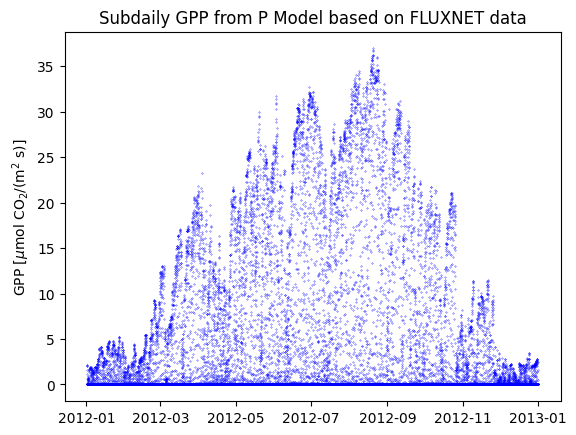

In [18]:
gC_to_mumol =  0.0833  # 1 µg C m⁻² s⁻¹ × (1 µmol C / 12.01 µg C) × (1 µmol CO₂ / 1 µmol C) = 0.0833 µmol CO₂ m⁻² s⁻¹


# Calculate the photosynthetic environment
subdaily_env = pyrealm.pmodel.PModelEnvironment(
    tc=site_temp.values,
    vpd=site_vpd.values,
    co2=site_co2.values,
    patm=site_patm.values,
)

# Create the fast slow scaler
fsscaler = pyrealm.pmodel.SubdailyScaler(datetime_subdaily)

# Set the acclimation window as the values within a one hour window centred on noon
fsscaler.set_window(
    window_center=np.timedelta64(12, "h"),
    half_width=np.timedelta64(30, "m"),
)

# Fit the P Model with fast and slow responses
pmodel_subdaily = pyrealm.pmodel.SubdailyPModel(
    env=subdaily_env,
    fs_scaler=fsscaler,
    allow_holdover=True,
    ppfd=site_ppfd.values,
    fapar=site_fapar.values,
)
#pmodel_subdaily.gpp[pmodel_subdaily.gpp <= 0] = np.nan
plt.figure(0)
plt.plot(datetime_subdaily, pmodel_subdaily.gpp*gC_to_mumol, color="blue",linestyle="",marker=".",markersize=0.5,label="GPP")
plt.title("Subdaily GPP from P Model based on FLUXNET data")
# plt.ylabel("GPP [umol CO2/m2/s]") how to write mocro mol with greek letter:
plt.ylabel(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
#plt.axes().set_ylabel("GPP (umol CO2/m2/s)") # TODO: check units

# sum to daily gpp
# gpp_daily = np.add.reduceat(pmodel_subdaily.gpp,np.arange(0, len(pmodel_subdaily.gpp), 48))
# days=np.arange(datetime(2012, 1, 1, 0, 00),
#         datetime(2013,1,1,0,0),
#         np.timedelta64(1, "D"))
# plt.figure(1)
# plt.plot(days, gpp_daily)